In [20]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
import seaborn as sns

sns.set(style='whitegrid')


In [13]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [26]:

start = datetime.datetime(2007, 1, 1)
end = datetime.datetime(2025,2,10)

tickers = ['AAPL', 'NVDA', 'MSFT', 'QCOM', 'AMD', 'INTU']

df = yf.download(tickers, start, end)['Close']

[*********************100%***********************]  6 of 6 completed


[('AAPL', 'AMD'), ('AAPL', 'MSFT'), ('AAPL', 'QCOM'), ('AMD', 'INTU'), ('AMD', 'MSFT'), ('AMD', 'QCOM'), ('INTU', 'MSFT'), ('INTU', 'QCOM'), ('MSFT', 'QCOM')]


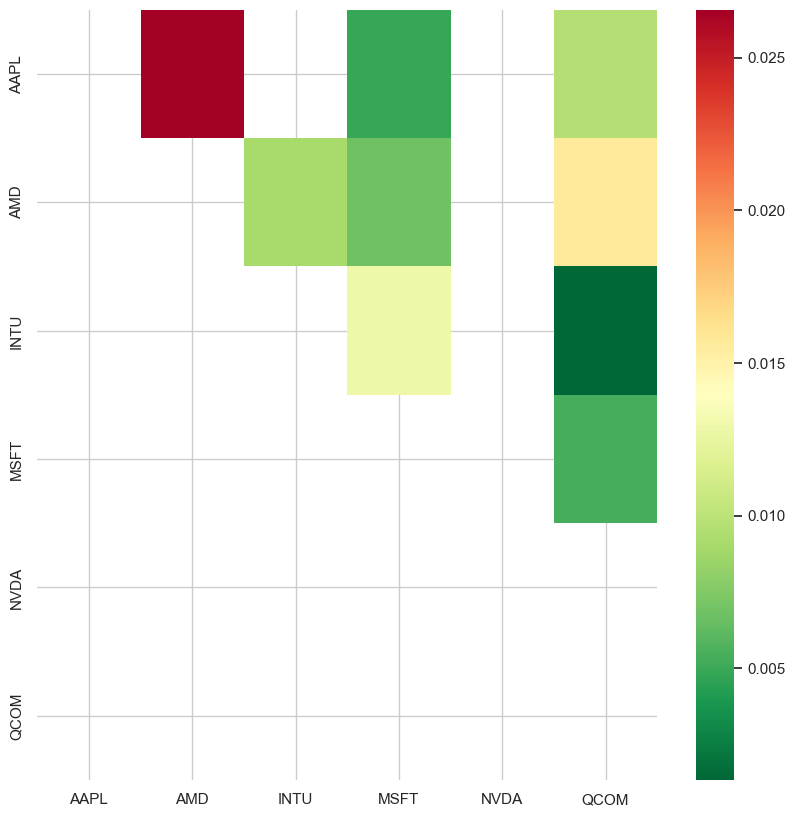

In [27]:
scores, pvalues, pairs = find_cointegrated_pairs(df)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [28]:

S1 = df['QCOM']
S2 = df['AMD']

score, pvalue, _ = coint(S1, S2)
pvalue

0.014130517540490474

Date
2007-01-03     24.366753
2007-01-04     25.466057
2007-01-05     25.166843
2007-01-08     24.887133
2007-01-09     24.613930
                 ...    
2025-02-03    169.326996
2025-02-04    172.111954
2025-02-05    174.916840
2025-02-06    168.411926
2025-02-07    167.059219
Name: QCOM, Length: 4555, dtype: float64

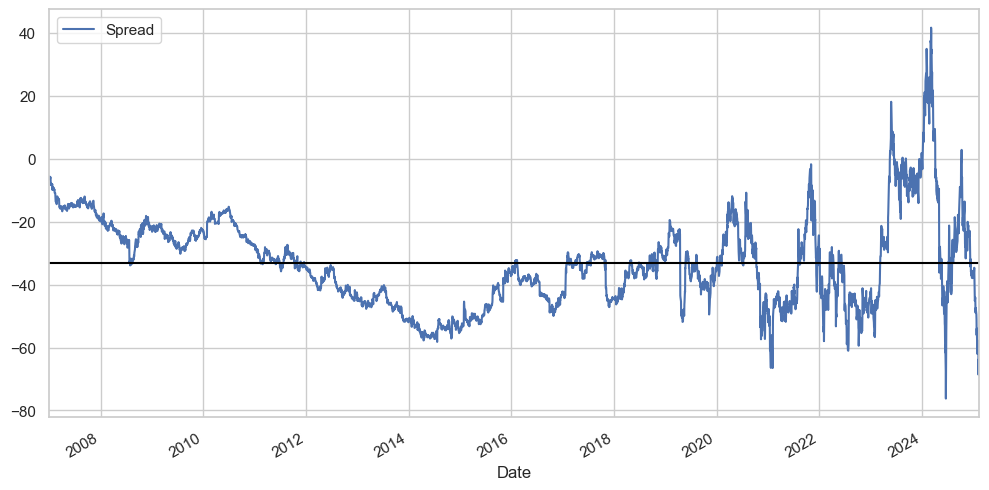

In [33]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['QCOM']
b = results.params['QCOM']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2007-01-01', '2025-02-10')
plt.legend(['Spread']);

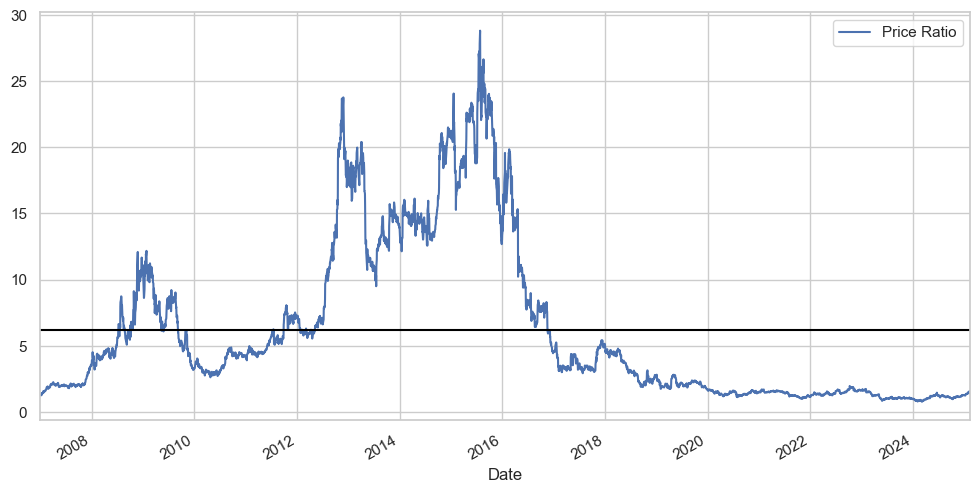

In [34]:

ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2007-01-01', '2025-02-10')
plt.legend(['Price Ratio']);

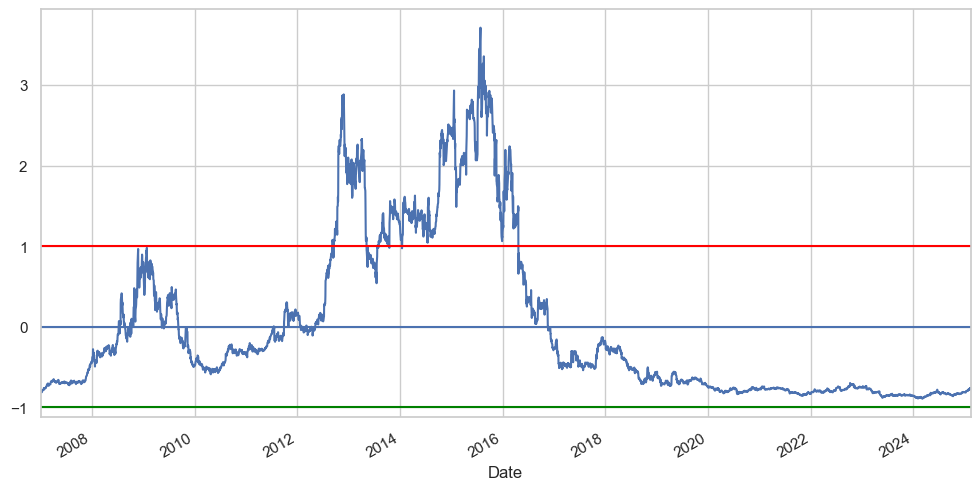

In [35]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2007-01-01', '2025-02-10')
plt.show()

[*********************100%***********************]  2 of 2 completed


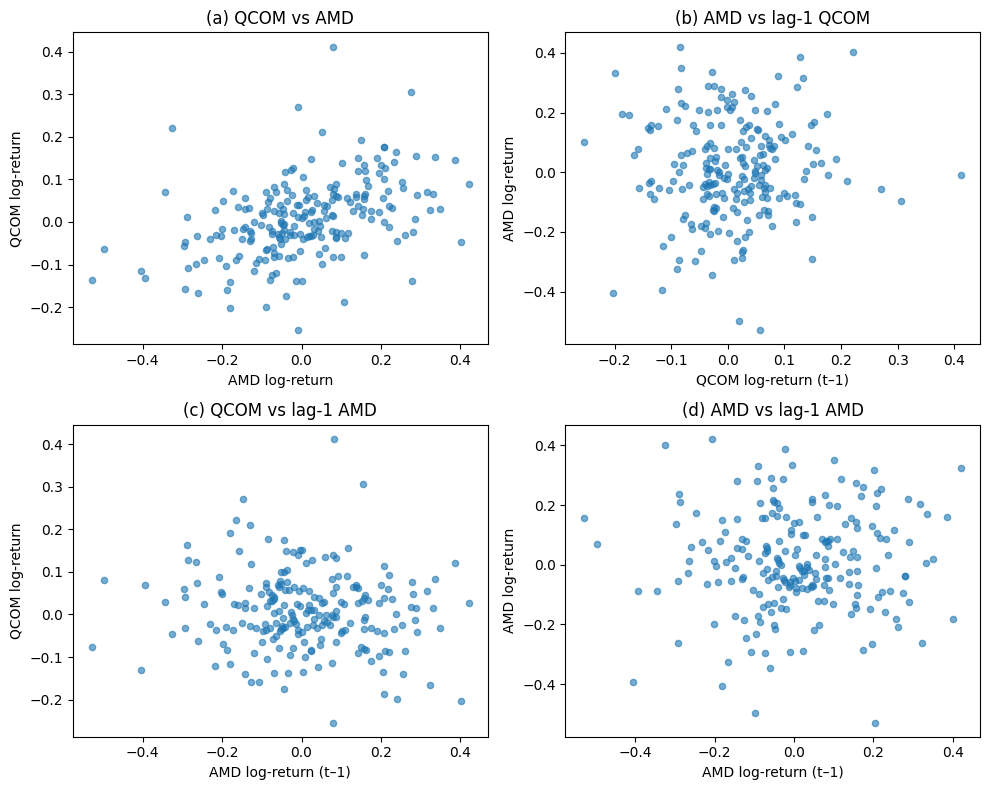

In [6]:
tickers = ["QCOM", "AMD"]
raw = yf.download(tickers, start="2007-01-01", end="2025-02-10")["Close"]

# 3) Resample to month-end and compute log-returns
monthly = raw.resample("M").last()
logret = np.log(monthly / monthly.shift(1))

# 4) Create 1‐month lags
logret["QCOM_lag1"] = logret["QCOM"].shift(1)
logret["AMD_lag1"]  = logret["AMD"].shift(1)

# 5) Drop any rows with NaNs (first row, etc.)
df = logret.dropna()

# 6) Make 2×2 scatterplot, mirroring panels (a)–(d) in your figure
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# (a) concurrent QCOM vs AMD
axes[0,0].scatter(df["AMD"], df["QCOM"], alpha=0.6, s=20)
axes[0,0].set_xlabel("AMD log-return")
axes[0,0].set_ylabel("QCOM log-return")
axes[0,0].set_title("(a) QCOM vs AMD")

# (b) AMD vs lag-1 QCOM
axes[0,1].scatter(df["QCOM_lag1"], df["AMD"], alpha=0.6, s=20)
axes[0,1].set_xlabel("QCOM log-return (t–1)")
axes[0,1].set_ylabel("AMD log-return")
axes[0,1].set_title("(b) AMD vs lag-1 QCOM")

# (c) QCOM vs lag-1 AMD
axes[1,0].scatter(df["AMD_lag1"], df["QCOM"], alpha=0.6, s=20)
axes[1,0].set_xlabel("AMD log-return (t–1)")
axes[1,0].set_ylabel("QCOM log-return")
axes[1,0].set_title("(c) QCOM vs lag-1 AMD")

# (d) AMD vs lag-1 AMD  (the “auto‐scatter” for AMD)
axes[1,1].scatter(df["AMD_lag1"], df["AMD"], alpha=0.6, s=20)
axes[1,1].set_xlabel("AMD log-return (t–1)")
axes[1,1].set_ylabel("AMD log-return")
axes[1,1].set_title("(d) AMD vs lag-1 AMD")

plt.tight_layout()
plt.show()

# Save the plot to the specified directory
plt.savefig("Project Report #3/plots/scatter_plot.png", bbox_inches='tight')
plt.close()


In [8]:
start = datetime.datetime(2007, 1, 1)
end = datetime.datetime(2025,2,10)

tickers = ['AMD', 'QCOM']

df = yf.download(tickers, start, end)['Close']


[*********************100%***********************]  2 of 2 completed


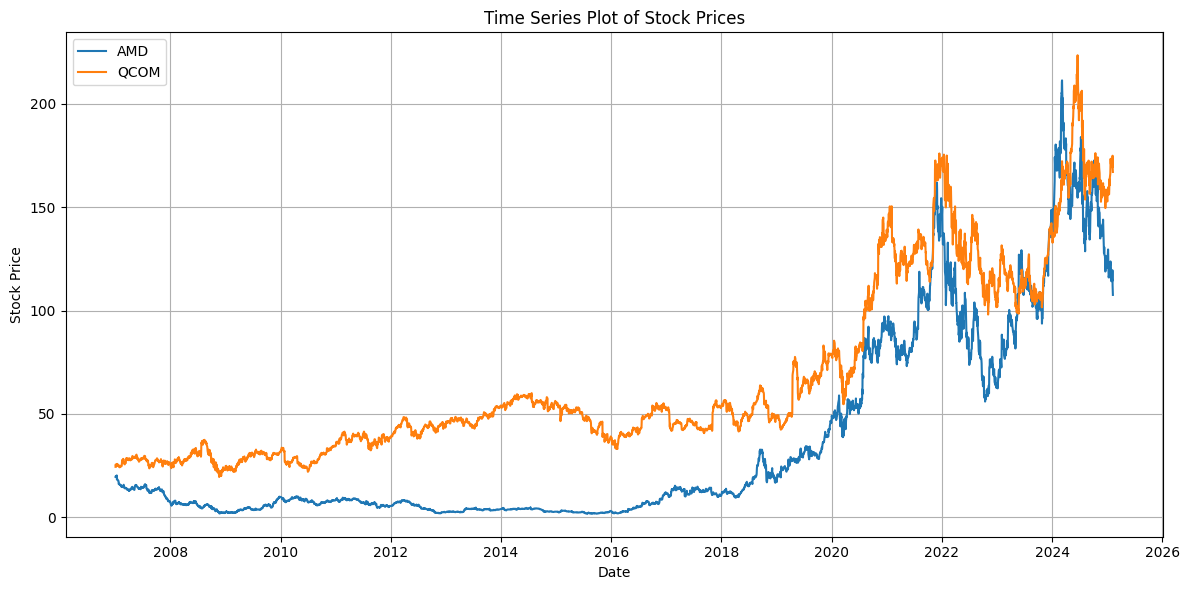

In [9]:
# Create a time series plot
plt.figure(figsize=(12, 6))
for ticker in df.columns:
    plt.plot(df.index, df[ticker], label=ticker)

plt.title('Time Series Plot of AMD and QCOM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()